In [186]:
#### welcome to the morphing with batchOT example

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [187]:
## generating the datasets
def sample_mixture_of_gaussians(n_samples, means, sigmas, weights, random_state=None):
    """
    Sample from a 1D mixture of Gaussians.

    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    means : list or np.ndarray
        Means of the Gaussian components.
    sigmas : list or np.ndarray
        Standard deviations of the Gaussian components.
    weights : list or np.ndarray
        Mixture weights (should sum to 1).
    random_state : int or None
        Seed for reproducibility.

    Returns
    -------
    samples : np.ndarray
        Array of shape (n_samples,) drawn from the mixture.
    """
    rng = np.random.default_rng(seed=random_state)
    means = np.array(means)
    sigmas = np.array(sigmas)
    weights = np.array(weights)

    # Choose component for each sample
    components = rng.choice(len(weights), size=n_samples, p=weights)

    # Sample from chosen components
    samples = rng.normal(loc=means[components], scale=sigmas[components])
    return samples

# Define mixture parameters for Distribution 1
means1  = [0.0,  2.0, -2.0]
sigmas1 = [1.0,  0.5,  1.0]
weights1= [0.5,  0.3,  0.2]

# Define mixture parameters for Distribution 2
means2  = [2.0, -1.0,  4.0]
sigmas2 = [0.8,  1.2,  0.9]
weights2= [0.4,  0.4,  0.2]

N = 300_000  # Total number of samples

# Sample distributions
x0 = sample_mixture_of_gaussians(N, means1, sigmas1, weights1, random_state=42).reshape(-1,1)
x1 = sample_mixture_of_gaussians(N, means2, sigmas2, weights2, random_state=24).reshape(-1,1)

<Figure size 640x480 with 0 Axes>

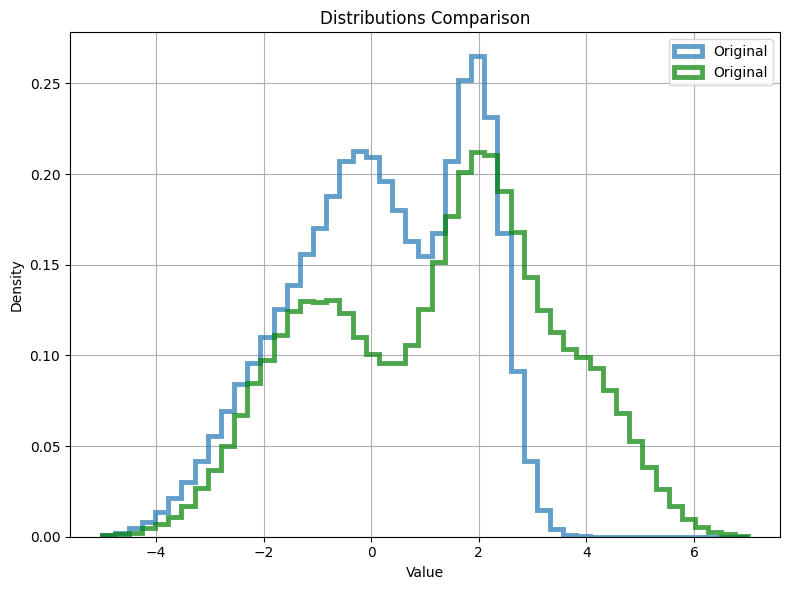

In [188]:
## validating the samples
fig = plt.figure()

plt.figure(figsize=(8, 6))
bin_edges = np.linspace(-5,7, 50)

# Plot Distribution (x0)
plt.hist(
        x0, 
        bins=bin_edges, 
        histtype='step', 
        linewidth=3.5, 
        alpha=0.7, 
        density=True, 
        color='C0', 
        label='Original'
    )

# Plot Distributionn (x1)
plt.hist(
        x1, 
        bins=bin_edges, 
        histtype='step', 
        linewidth=3.5, 
        alpha=0.7, 
        density=True, 
        color='green', 
        label='Original'
    )

# Enhance Plot
plt.title("Distributions Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
    
plt.legend()
plt.tight_layout()
plt.savefig('plots/generation_validation.png')

In [189]:
### creating the training and test datasets
x0_train, x0_val, x1_train, x1_val = train_test_split(
    x0, x1, test_size=0.3, random_state=42
)

# Convert to float32 for PyTorch
x0_train = x0_train.astype(np.float32)
x1_train = x1_train.astype(np.float32)
x0_val = x0_val.astype(np.float32)
x1_val = x1_val.astype(np.float32)


class OTDataset(Dataset):
    def __init__(self, x0, x1):
        """
        Dataset for Optimal Transport Matching.

        Parameters
        ----------
        x0 : np.ndarray
            Source distribution samples, shape (N, 1).
        x1 : np.ndarray
            Target distribution samples, shape (N, 1).
        """
        self.x0 = x0
        self.x1 = x1
        self.N = self.x0.shape[0]

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.x0[idx], self.x1[idx]
    
# Create Dataset
train_dataset = OTDataset(x0_train, x1_train)
val_dataset = OTDataset(x0_val, x1_val)

In [190]:
### creating the DNN model
class Regressor(nn.Module):
    def __init__(self, input_dim=1):
        super(Regressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)
    
# Initialize network, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [191]:
#### trainining loop
model.train()
total_loss = 0.0
num_batches = 0


def train(model, train_dataset, optimizer, criterion, epoch, batch_size=512):
    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0.0
    num_batches = 0

    for batch_idx, (batch_x0, batch_x1) in enumerate(loader):
        batch_x0 = batch_x0.numpy().reshape(-1,1)
        batch_x1 = batch_x1.numpy().reshape(-1,1)

        # Perform batch OT matching within the current batch
        cost_matrix = np.square(batch_x0 - batch_x1.T)  # Shape: (batch_size, batch_size)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # Get matched pairs
        matched_x0 = batch_x0[row_ind]
        matched_x1 = batch_x1[col_ind]

        # Convert to tensors
        inputs = torch.from_numpy(matched_x0).to(device)
        targets = torch.from_numpy(matched_x1).to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Epoch [{epoch}] Average Training Loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model, val_dataset, criterion, batch_size=32):
    model.eval()
    loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    total_loss = 0.0
    num_batches = 0

    all_inputs = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch_x0, batch_x1 in loader:
            batch_size_current = batch_x0.shape[0]
            batch_x0 = batch_x0.numpy().reshape(-1,1)
            batch_x1 = batch_x1.numpy().reshape(-1,1)

            # Perform batch OT matching within the current batch
            cost_matrix = np.square(batch_x0 - batch_x1.T)  # Shape: (batch_size, batch_size)
            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            # Get matched pairs
            matched_x0 = batch_x0[row_ind]
            matched_x1 = batch_x1[col_ind]

            # Convert to tensors
            inputs = torch.from_numpy(matched_x0).to(device)
            targets = torch.from_numpy(matched_x1).to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            num_batches += 1

            # Store for plotting
            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())

    avg_loss = total_loss / num_batches
    print(f"Validation Average Loss: {avg_loss:.4f}")

    # Concatenate all data for plotting
    all_inputs = np.vstack(all_inputs)
    all_targets = np.vstack(all_targets)
    all_predictions = np.vstack(all_predictions)

    return avg_loss, all_inputs, all_targets, all_predictions


In [192]:
num_epochs = 55
batch_size = 512

# Lists to store loss history
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    print(f"--- Epoch {epoch} ---")
    train_loss = train(model, train_dataset, optimizer, criterion, epoch, batch_size=batch_size)
    val_loss, inputs, targets, predictions = evaluate(model, val_dataset, criterion, batch_size=batch_size)
    
    # Append losses to history
    train_losses.append(train_loss)
    val_losses.append(val_loss)

--- Epoch 1 ---
Epoch [1] Average Training Loss: 1.5081
Validation Average Loss: 0.1276
--- Epoch 2 ---
Epoch [2] Average Training Loss: 0.1216
Validation Average Loss: 0.1165
--- Epoch 3 ---
Epoch [3] Average Training Loss: 0.1127
Validation Average Loss: 0.1098
--- Epoch 4 ---
Epoch [4] Average Training Loss: 0.1071
Validation Average Loss: 0.1047
--- Epoch 5 ---
Epoch [5] Average Training Loss: 0.1023
Validation Average Loss: 0.1005
--- Epoch 6 ---
Epoch [6] Average Training Loss: 0.1004
Validation Average Loss: 0.0980
--- Epoch 7 ---
Epoch [7] Average Training Loss: 0.0958
Validation Average Loss: 0.0970
--- Epoch 8 ---
Epoch [8] Average Training Loss: 0.0896
Validation Average Loss: 0.0933
--- Epoch 9 ---
Epoch [9] Average Training Loss: 0.0926
Validation Average Loss: 0.0919
--- Epoch 10 ---
Epoch [10] Average Training Loss: 0.0925
Validation Average Loss: 0.0908
--- Epoch 11 ---
Epoch [11] Average Training Loss: 0.0855
Validation Average Loss: 0.0895
--- Epoch 12 ---
Epoch [12] 

In [193]:
def plot_histograms(x0, x1, x1_pred, bins=100):
    plt.figure(figsize=(8, 6))
    bin_edges = np.linspace(-5,7, 80)

    # Plot Distribution 1 (x0)
    plt.hist(
        x0, 
        bins=bin_edges, 
        histtype='step', 
        linewidth=3.5, 
        alpha=0.7, 
        density=True, 
        color='C0', 
        label='Original'
    )
    
    # Plot Distribution 2 (x1)
    plt.hist(
        x1, 
        bins=bin_edges, 
        histtype='step', 
        linewidth=3.5, 
        alpha=0.7, 
        density=True, 
        color='C1', 
        label='Target'
    )
    
    # Plot Distribution 1 mapped to 2 via NN (x1_pred)
    plt.hist(
        x1_pred, 
        bins=bin_edges, 
        histtype='step', 
        linewidth=3.5, 
        alpha=0.7, 
        density=True, 
        color='C2', 
        label='Morphed'
    )
    
    # Enhance Plot
    plt.title("Distributions Comparison")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('results_dnn.png')

def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_dnn.png')

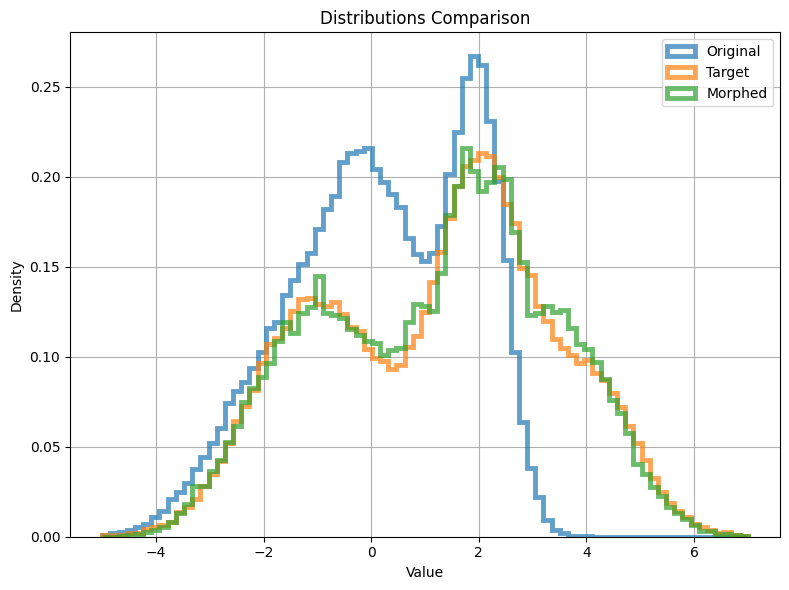

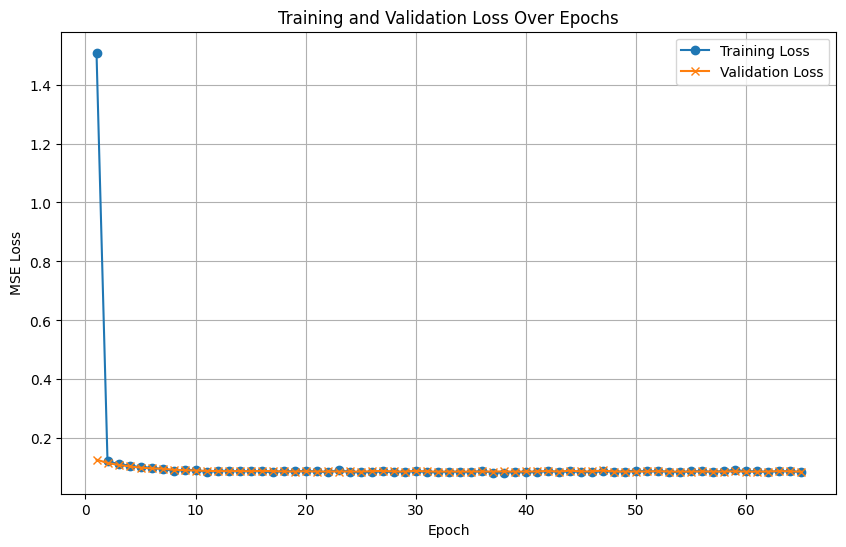

In [194]:
# Plot the histograms
plot_histograms(inputs, targets, predictions)

# Plot the training and validation loss curves
plot_loss_curves(train_losses, val_losses)